In [25]:
from PIL import Image
from PIL.ExifTags import TAGS

# To save time, we can extract metadata algorithmically
# Afterwards, we compile them into an index .txt file
# placed at the same directory as our dataset

def extract_exif_data(image_path):
    try:
        #open the image file
        with Image.open(image_path) as img:
            # extract Exif data
            exif_data = img._getexif()

            # Check existence of Exif data
            if exif_data is not None:
                # IF meron, itereate
                for tag, value in exif_data.items():
                    tag_name = TAGS.get(tag, tag)
                    
                    # Look for tags related to shutter speed and exposure time
                    if "ExposureTime" in tag_name:
                        exposure_time = str(value)
                    elif "ShutterSpeedValue" in tag_name:
                        shutter_speed = str(value)

                return exposure_time, shutter_speed

    except Exception as e:
        print(f"Error: {e}")
    
    return None, None

# Example usage

for i in range(1, 10):
    image_path = f"exposure_change/et_0{i}.jpg"
    exposure_time, shutter_speed = extract_exif_data(image_path)

    if exposure_time and shutter_speed:
        print(f"et_0{i}")
        print(f"Exposure Time: {exposure_time}")
        print(f"Shutter Speed: {shutter_speed}")
    else:
        print("Exif data not found or invalid.")

        
for i in range(10, 20):
    image_path = f"exposure_change/et_{i}.jpg"
    exposure_time, shutter_speed = extract_exif_data(image_path)

    if exposure_time and shutter_speed:
        print(f"et_{i}")
        print(f"Exposure Time: {exposure_time}")
        print(f"Shutter Speed: {shutter_speed}")
    else:
        print("Exif data not found or invalid.")

et_01
Exposure Time: 0.01
Shutter Speed: 29.8973
et_02
Exposure Time: 0.0125
Shutter Speed: 29.8973
et_03
Exposure Time: 0.016666666
Shutter Speed: 29.8973
et_04
Exposure Time: 0.02
Shutter Speed: 29.8973
et_05
Exposure Time: 0.025
Shutter Speed: 29.8973
et_06
Exposure Time: 0.033333333
Shutter Speed: 29.8973
et_07
Exposure Time: 0.05
Shutter Speed: 29.8973
et_08
Exposure Time: 0.099996
Shutter Speed: 29.8973
et_09
Exposure Time: 0.008
Shutter Speed: 29.8973
et_10
Exposure Time: 0.00625
Shutter Speed: 29.8973
et_11
Exposure Time: 0.00625
Shutter Speed: 29.8973
et_12
Exposure Time: 0.00625
Shutter Speed: 29.8973
et_13
Exposure Time: 0.005
Shutter Speed: 29.8973
et_14
Exposure Time: 0.004
Shutter Speed: 29.8973
et_15
Exposure Time: 0.003125
Shutter Speed: 29.8973
et_16
Exposure Time: 0.0025
Shutter Speed: 29.8973
et_17
Exposure Time: 0.002
Shutter Speed: 29.8973
et_18
Exposure Time: 0.0015625
Shutter Speed: 29.8973
et_19
Exposure Time: 0.00125
Shutter Speed: 29.8973


In [20]:
# we will be dealing with the reciprocal of the shutter speed
1/29.8973

0.03344783642670074

In [53]:
# converting jpg to png

import os
from PIL import Image

def convert_jpg_to_png(input_path, output_path):
    try:
        with Image.open(input_path) as img:
            img.save(output_path, 'PNG')
            print(f"Conversion successful. PNG image saved at {output_path}")
    except Exception as e:
        print(f"Error: {e}")

def batch_convert_jpg_to_png(input_directory, output_directory):
    # Create the output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)

    # Loop through all files in the input directory
    for filename in os.listdir(input_directory):
        if filename.endswith(".jpg"):
            input_path = os.path.join(input_directory, filename)
            # Change the extension to PNG for the output file
            output_path = os.path.join(output_directory, os.path.splitext(filename)[0] + ".png")

            # Convert JPG to PNG
            convert_jpg_to_png(input_path, output_path)

# Replace 'input_directory' and 'output_directory' with your directory paths
input_directory = 'exposure_change'
output_directory = 'exposure_change'

batch_convert_jpg_to_png(input_directory, output_directory)


Conversion successful. PNG image saved at exposure_change\et_01.png
Conversion successful. PNG image saved at exposure_change\et_02.png
Conversion successful. PNG image saved at exposure_change\et_03.png
Conversion successful. PNG image saved at exposure_change\et_04.png
Conversion successful. PNG image saved at exposure_change\et_05.png
Conversion successful. PNG image saved at exposure_change\et_06.png
Conversion successful. PNG image saved at exposure_change\et_07.png
Conversion successful. PNG image saved at exposure_change\et_08.png
Conversion successful. PNG image saved at exposure_change\et_09.png
Conversion successful. PNG image saved at exposure_change\et_10.png
Conversion successful. PNG image saved at exposure_change\et_11.png
Conversion successful. PNG image saved at exposure_change\et_12.png
Conversion successful. PNG image saved at exposure_change\et_13.png
Conversion successful. PNG image saved at exposure_change\et_14.png
Conversion successful. PNG image saved at exposu

In [19]:
import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cProfile
import colorsys
import tqdm

In [6]:
def load_exposures(source_dir, channel=0):
    filenames = []
    exposure_times = []
    f = open(os.path.join(source_dir, 'image_list.txt'))
    for line in f:
        if (line[0] == '#'):
            continue
        print(line[0])
        (filename, exposure, *rest) = line.split()
        filenames += [filename]
        exposure_times += [exposure]
    
    img_list = [cv2.imread(os.path.join(source_dir, f), 1) for f in filenames]
    img_list = [img[:,:,channel] for img in img_list]
    exposure_times = np.array(exposure_times, dtype=np.float32)

    return (img_list, exposure_times)

In [7]:
def hdr_debvec(img_list, exposure_times):
    B = [math.log(e,2) for e in exposure_times] # log of (delta t)
    l = 10
    w = [z if z <= 0.5*255 else 255-z for z in range(256)] 

    small_img = [cv2.resize(img, (10, 10)) for img in img_list]
    Z = [img.flatten() for img in small_img]

    #samples = [(random.randint(0, img_list[0].shape[0]-1), random.randint(0, img_list[0].shape[1]-1)) for i in range(50)]
    #Z = []
    #for img in img_list:
    #    Z += [[img[r[0]][r[1]] for r in samples]]
    
    plt.imshow(small_img[0], cmap='gray')
    #for i in samples:
    #    plt.scatter(i[1], i[0], c='r', s=10)
    plt.show()
    plt.imshow(small_img[1], cmap='gray')
    #for i in samples:
    #    plt.scatter(i[1], i[0], c='r', s=10)
    plt.show()
    plt.imshow(small_img[2], cmap='gray')
    #for i in samples:
    #    plt.scatter(i[1], i[0], c='r', s=10)
    plt.show()
     
    #print(np.shape(Z), samples)
    
    return response_curve_solver(Z, B, l, w)



# def hdr_debvec(img_list, exposure_times):
#     B = [math.log(e,2) for e in exposure_times]
#     l = 10
#     w = [z if z <= 0.5*255 else 255-z for z in range(256)] 

#     small_img = [cv2.resize(img, (10, 10)) for img in img_list]
#     Z = [img.flatten() for img in small_img]

    
#     plt.imshow(small_img[0], cmap='gray')
   
#     plt.imshow(small_img[1], cmap='gray')

#     plt.imshow(small_img[2], cmap='gray')

#     plt.show()
  
#     return response_curve_solver(Z, B, l, w)

In [8]:
def response_curve_solver(Z, B, l, w):
    n = 256
    A = np.zeros(shape=(np.size(Z, 0)*np.size(Z, 1)+n+1, n+np.size(Z, 1)), dtype=np.float32)
    b = np.zeros(shape=(np.size(A, 0), 1), dtype=np.float32)

    # Include the data−fitting equations
    k = 0
    for i in range(np.size(Z, 1)):
        for j in range(np.size(Z, 0)):
            z = Z[j][i]
            wij = w[z]
            A[k][z] = wij
            A[k][n+i] = -wij
            b[k] = wij*B[j]
            k += 1
    
    # Fix the curve by setting its middle value to 0
    A[k][128] = 1
    k += 1

    # Include the smoothness equations
    for i in range(n-1):
        A[k][i]   =    l*w[i+1]
        A[k][i+1] = -2*l*w[i+1]
        A[k][i+2] =    l*w[i+1]
        k += 1

    print(np.shape(A))
    print(np.shape(b))
    
    # Solve the system using SVD
    x = np.linalg.lstsq(A, b)[0]
    g = x[:256]
    lE = x[256:]

    return g, lE

In [28]:
def construct_radiance_map(g, Z, ln_t, w):
    acc_E = [0]*len(Z[0])
    ln_E = [0]*len(Z[0])
    
    pixels, imgs = len(Z[0]), len(Z)
    for i in range(pixels):
        acc_w = 0
        for j in range(imgs):
            z = Z[j][i]
            acc_E[i] += w[z]*(g[z] - ln_t[j])
            acc_w += w[z]
        ln_E[i] = acc_E[i]/acc_w if acc_w > 0 else acc_E[i]
        acc_w = 0
        if i % 100000 == 0:
            print (f"{100*float(i)/float(pixels)}")
    
    return ln_E




In [15]:
def construct_hdr(img_list, response_curve, exposure_times):
    # Construct radiance map for each channels
    img_size = img_list[0][0].shape
    w = [z if z <= 0.5*255 else 255-z for z in range(256)]
    ln_t = np.log2(exposure_times)

    vfunc = np.vectorize(lambda x:math.exp(x))
    hdr = np.zeros((img_size[0], img_size[1], 3), 'float32')

    # construct radiance map for BGR channels
    for i in range(3):
        Z = [img.flatten().tolist() for img in img_list[i]]
        E = construct_radiance_map(response_curve[i], Z, ln_t, w)
        # Exponational each channels and reshape to 2D-matrix
        hdr[..., i] = np.reshape(vfunc(E), img_size)

    return hdr

e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e


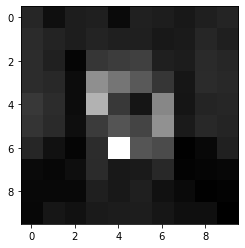

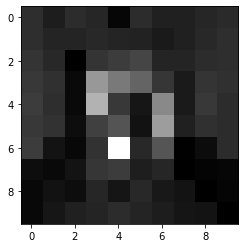

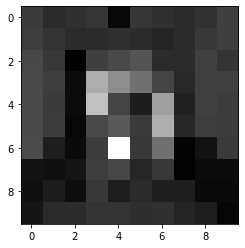

(2157, 356)
(2157, 1)


C:\Users\Lyle\AppData\Local\Temp\ipykernel_29064\128151948.py:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A, b)[0]


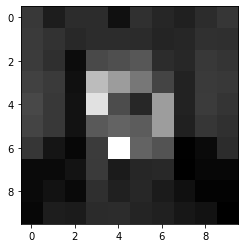

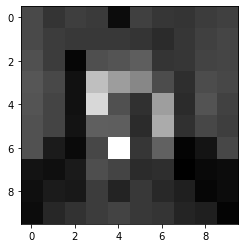

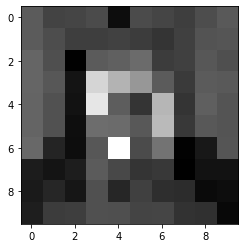

(2157, 356)
(2157, 1)


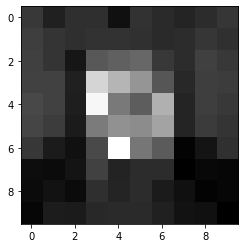

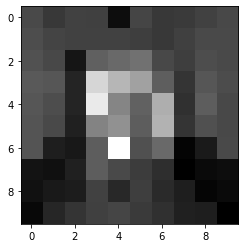

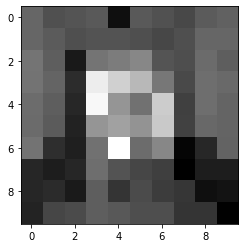

(2157, 356)
(2157, 1)


In [16]:
# Loading exposure images into a list
dirname = 'exposure_change'
img_list_b, exposure_times = load_exposures(dirname, 0)
img_list_g, exposure_times = load_exposures(dirname, 1)
img_list_r, exposure_times = load_exposures(dirname, 2)

gb, _ = hdr_debvec(img_list_b, exposure_times)
gg, _ = hdr_debvec(img_list_g, exposure_times)
gr, _ = hdr_debvec(img_list_r, exposure_times)

In [12]:
def alignment(img_list):
    median = [np.median(img) for img in img_list]
    binary_thres_img = [cv2.threshold(img_list[i], median[i], 255, cv2.THRESH_BINARY)[1] for i in range(len(img_list))]
    mask_img = [cv2.inRange(img_list[i], median[i]-20, median[i]+20) for i in range(len(img_list))]

    a=binary_thres_img[0]-binary_thres_img[1]
    s=0
    for x in np.nditer(a):
        s+=1 if x == 255 else 0
    print(s)

    for i in range(1, len(img_list)):
        offset = []
        diff = float('Inf')
        tmp_offset = []
        for y in range(-3, 4):
            for x in range(-3, 4):
                error = 0
                for row in range(img_list[0].shape[0]):
                    for col in range(img_list[0].shape[1]):
                        if x+col < 0 or y+row < 0 or x+col >= img_list[0].shape[1] or y+row >= img_list[0].shape[1]:
                            continue
                        if mask_img[0][row][col] == 255:
                            continue
                        error += 1 if binary_thres_img[0][row][col] != binary_thres_img[i][row+y][col+x] else 0
                if error < diff:
                    tmp_offset = [y, x]
                    diff = error
                print([y, x], error)
        offset += [tmp_offset]
        print('-----------'+str(offset[-1]))

In [13]:
def median_threshold_bitmap_alignment(img_list):
    median = [np.median(img) for img in img_list]
    binary_thres_img = [cv2.threshold(img_list[i], median[i], 255, cv2.THRESH_BINARY)[1] for i in range(len(img_list))]
    mask_img = [cv2.inRange(img_list[i], median[i]-20, median[i]+20) for i in range(len(img_list))]
    
    
    print(median,binary_thres_img[0])
    plt.imshow(mask_img[0], cmap='gray')
    plt.show()
    
    max_offset = np.max(img_list[0].shape)
    levels = 5
    print(max_offset, levels)
    print(img_list[0].shape)

    global_offset = []
    for i in range(0, len(img_list)):
        offset = [[0,0]]
        for level in range(levels, -1, -1):
            scaled_img = cv2.resize(binary_thres_img[i], (0, 0), fx=1/(2**level), fy=1/(2**level))
            ground_img = cv2.resize(binary_thres_img[0], (0, 0), fx=1/(2**level), fy=1/(2**level))
            ground_mask = cv2.resize(mask_img[0], (0, 0), fx=1/(2**level), fy=1/(2**level))
            mask = cv2.resize(mask_img[i], (0, 0), fx=1/(2**level), fy=1/(2**level))
            
            
            #cv2.imwrite('mtb-level_'+str(level)+'.jpg',ground_img)
            #cv2.imwrite('mask-level_'+str(level)+'.jpg',ground_mask)
            level_offset = [0, 0]
            diff = float('Inf')
            for y in [-1, 0, 1]:
                for x in [-1, 0, 1]:
                    off = [offset[-1][0]*2+y, offset[-1][1]*2+x]
                    error = 0
                    for row in range(ground_img.shape[0]):
                        for col in range(ground_img.shape[1]):
                            if off[1]+col < 0 or off[0]+row < 0 or off[1]+col >= ground_img.shape[1] or off[0]+row >= ground_img.shape[1]:
                                continue
                            if ground_mask[row][col] == 255:
                                continue
                            error += 1 if ground_img[row][col] != scaled_img[y+off[0]][x+off[1]] else 0
                    if error < diff:
                        level_offset = off
                        diff = error
                    print(off, error)
            offset += [level_offset]
            print('-----------'+str(offset[-1]))
        global_offset += [offset[-1]]
        #global_offset += [weighted_offset]
              
        print(offset, global_offset)
    
    return global_offset

[19.0, 34.0, 45.0, 57.0, 70.0, 94.0, 129.0, 184.0, 22.0, 14.0, 15.0, 15.0, 10.0, 7.0, 5.0, 3.0, 2.0, 1.0, 1.0] [[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


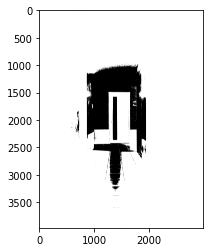

3968 5
(3968, 2976)
[-1, -1] 1221
[-1, 0] 1221
[-1, 1] 1221
[0, -1] 1214
[0, 0] 0
[0, 1] 1214
[1, -1] 1208
[1, 0] 0
[1, 1] 0
-----------[0, 0]
[-1, -1] 4781
[-1, 0] 4781
[-1, 1] 4781
[0, -1] 10
[0, 0] 10
[0, 1] 10
[1, -1] 10
[1, 0] 10
[1, 1] 10
-----------[0, -1]
[-1, -3] 18980
[-1, -2] 18980
[-1, -1] 18980
[0, -3] 57
[0, -2] 57
[0, -1] 57
[1, -3] 56
[1, -2] 56
[1, -1] 56
-----------[1, -3]
[1, -7] 150
[1, -6] 75622
[1, -5] 75550
[2, -7] 150
[2, -6] 150
[2, -5] 75506
[3, -7] 150
[3, -6] 150
[3, -5] 150
-----------[1, -7]
[1, -15] 624
[1, -14] 624
[1, -13] 303104
[2, -15] 303036
[2, -14] 615
[2, -13] 303031
[3, -15] 614
[3, -14] 614
[3, -13] 614
-----------[3, -15]
[5, -31] 0
[5, -30] 0
[5, -29] 0
[6, -31] 0
[6, -30] 0
[6, -29] 0
[7, -31] 0
[7, -30] 0
[7, -29] 0
-----------[5, -31]
[[0, 0], [0, 0], [0, -1], [1, -3], [1, -7], [3, -15], [5, -31]] [[5, -31]]
[-1, -1] 1221
[-1, 0] 1221
[-1, 1] 1221
[0, -1] 0
[0, 0] 0
[0, 1] 0
[1, -1] 0
[1, 0] 0
[1, 1] 0
-----------[0, -1]
[-1, -3] 4781
[-1,

KeyboardInterrupt: 

In [99]:
# MTB implementation

median_threshold_bitmap_alignment(img_list_b)

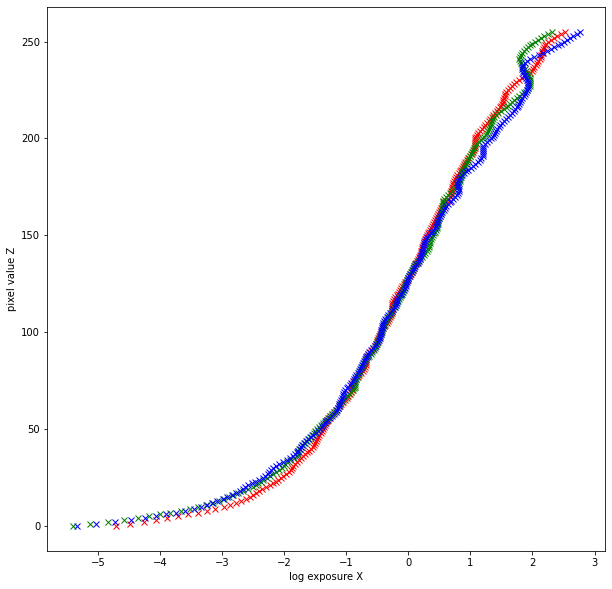

In [17]:
plt.figure(figsize=(10,10))
plt.plot(gr,range(256), 'rx')
plt.plot(gg,range(256), 'gx')
plt.plot(gb,range(256), 'bx')
plt.ylabel('pixel value Z')
plt.xlabel('log exposure X')
plt.show()

In [29]:
hdr = construct_hdr([img_list_b, img_list_g, img_list_r], [gb, gg, gr], exposure_times)

0.0
0.8468283905653833
1.6936567811307666
2.5404851716961496
3.387313562261533
4.234141952826916
5.080970343392299
5.927798733957683
6.774627124523066
7.621455515088449
8.468283905653832
9.315112296219215
10.161940686784598
11.008769077349983
11.855597467915366
12.70242585848075
13.549254249046133
14.396082639611516
15.242911030176899
16.089739420742283
16.936567811307665
17.78339620187305
18.63022459243843
19.477052983003816
20.323881373569197
21.170709764134582
22.017538154699967
22.864366545265348
23.711194935830733
24.558023326396114
25.4048517169615
26.25168010752688
27.098508498092265
27.94533688865765
28.79216527922303
29.638993669788416
30.485822060353797
31.332650450919182
32.17947884148457
33.026307232049945
33.87313562261533
34.719964013180714
35.5667924037461
36.413620794311484
37.26044918487686
38.10727757544225
38.95410596600763
39.800934356573016
40.647762747138394
41.49459113770378
42.341419528269164
43.18824791883455
44.03507630939993
44.88190469996531
45.7287330905306

In [38]:
import pickle
# Save HDR data to a pickle file
with open('output_hdr.pkl', 'wb') as f:
    pickle.dump(hdr, f)

In [30]:
print(np.log(hdr).max())

10.341147


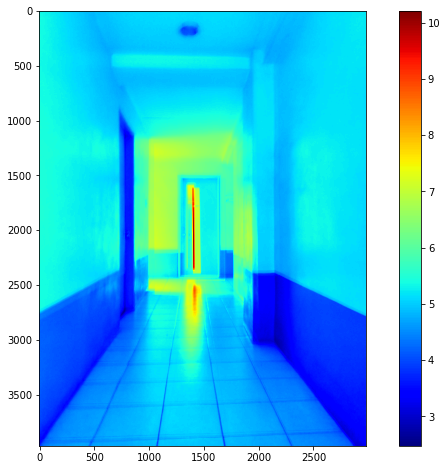

In [31]:
# Show false-color Radiance map (log value)
plt.figure(figsize=(12, 8))
plt.imshow(np.log(cv2.cvtColor(hdr, cv2.COLOR_BGR2GRAY)), cmap='jet')
plt.colorbar()
plt.show()

In [40]:
print(hdr.shape, hdr.dtype)
image = np.zeros((hdr.shape[0], hdr.shape[1], 3), 'float32')
image[..., 0] = hdr[..., 2]
image[..., 1] = hdr[..., 1]
image[..., 2] = hdr[..., 0]

f = open("167.hdr", "wb")
f.write(b"#?RADIANCE\n# Made with Python & Numpy\nFORMAT=32-bit_rle_rgbe\n\n")
header = "-Y {0} +X {1}\n".format(image.shape[0], image.shape[1]) 
f.write(bytes(header, encoding='utf-8'))

brightest = np.maximum(np.maximum(image[...,0], image[...,1]), image[...,2])
mantissa = np.zeros_like(brightest)
exponent = np.zeros_like(brightest)
np.frexp(brightest, mantissa, exponent)
scaled_mantissa = mantissa * 256.0 / brightest
rgbe = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)
rgbe[...,0:3] = np.around(image[...,0:3] * scaled_mantissa[...,None])
rgbe[...,3] = np.around(exponent + 128)

rgbe.flatten().tofile(f)
f.close()

(3968, 2976, 3) float32


In [51]:
type(gb)

numpy.ndarray

In [53]:
gb.shape

(256, 1)

In [55]:
import pandas as pd
df_gb = pd.DataFrame(gb)

In [58]:
df_gb.head(100)

,0
0,-5.338596
1,-5.035089
2,-4.731583
3,-4.460174
4,-4.246652
...,...
95,-0.493176
96,-0.475951
97,-0.463492
98,-0.454303
